**Script Description:** This script loads a pre-processed dataset, prepares features and target variables to perform sequential backward floating selection (SBFS).

**File Name:** 02_03_Feature_Selec_SBFS.ipynb

**Date:** 2025

**Created by:** Rob Alamgir

##### Import the relevant packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from xgboost import XGBRegressor
from mlxtend.evaluate import bias_variance_decomp
import winsound
from datetime import datetime
import shap

### Step 1: Load and preprocess the dataset

In [2]:
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_V6.csv"
complete_dataset = pd.read_csv(data_path)

column_to_remove = 'Porosity'  
complete_dataset = complete_dataset.drop(columns=[column_to_remove])
rename_dict = {"Porosity_BIS4D_SOM": "Porosity","BOFEK_2020_Physical Units": "BOFEK_PU", "Peat_Thickness_2022": "Peat_Thickness"}
complete_dataset.rename(columns=rename_dict, inplace=True)

# Data preprocessing
complete_dataset['Date'] = pd.to_datetime(complete_dataset['Date'], format='%Y-%m-%d')
complete_dataset['Source_ID'] = complete_dataset['Site_ID'].astype('category').cat.codes + 1
print(f"Rows and columns before removing NaNs: {complete_dataset.shape}")
filtered_df = complete_dataset.dropna(subset=['SENTEK_SMC']).copy()
filtered_df['BOFEK_PU'] = filtered_df['BOFEK_PU'].astype('category')
print(f"Rows and columns after removing NaNs: {filtered_df.shape}")

# Selected 17 features
Features = ['Sentinel_1_SMC', 'S1_Backscatter', 'S1_Backscatter_SD','S2_NDVI', 'S2_NDMI', 'MODIS_LAI', 'L8_9_LST',
            'STMP_1_015', 'WLEV_f', 'WTMP_f', 'ATMP_f', 'PET',
            'BD_5_15', 'Porosity', 'BOFEK_PU', 'Peat_Thickness', 'DOY']

X = filtered_df[Features]         # Features   
y = filtered_df['SENTEK_SMC']     # Predictor
groups = filtered_df["Source_ID"] # Groups for Leave-One-Group-Out
dates = filtered_df['Date']
print(f"Features (X): {X.shape}, Target (y): {y.shape}, Groups: {groups.shape}, Date: {dates.shape}")

Rows and columns before removing NaNs: (36056, 109)
Rows and columns after removing NaNs: (8368, 109)
Features (X): (8368, 17), Target (y): (8368,), Groups: (8368,), Date: (8368,)


### Step 2: Split the dataset

In [3]:
# Perform the train-test split with temporal separation
X_train, X_test, y_train, y_test, groups_train, groups_test, dates_train, dates_test = train_test_split(
    X, y, groups, dates,
    test_size=0.3,      # Reserve 30% for the test set
    shuffle=False)      # Ensure temporal order is maintained

#### Perform a couple of checks regarding the data split

In [4]:
# Verify temporal separation
print("\nEarliest date in training set:", dates_train.min())
print("Latest date in training set:", dates_train.max())
print("Earliest date in test set:", dates_test.min())
print("Latest date in test set:", dates_test.max())

# Ensure alignment of training data
X_train, y_train = X_train.align(y_train, join='inner', axis=0)
groups_train = groups_train.loc[X_train.index]
dates_train = dates_train.loc[X_train.index]  # Align dates_train with X_train

# Ensure alignment of test data
X_test, y_test = X_test.align(y_test, join='inner', axis=0)
groups_test = groups_test.loc[X_test.index]
dates_test = dates_test.loc[X_test.index]  # Align dates_test with X_test

# Verify alignment
assert X_train.index.equals(y_train.index) and X_train.index.equals(groups_train.index) and X_train.index.equals(dates_train.index), \
    "Rows in X_train, y_train, groups_train, and dates_train are misaligned!"

assert X_test.index.equals(y_test.index) and X_test.index.equals(groups_test.index) and X_test.index.equals(dates_test.index), \
    "Rows in X_test, y_test, groups_test, and dates_test are misaligned!"

# Print shapes for verification
print("Data shapes after splitting and alignment:")
print(f"Train set: X_train: {X_train.shape}, y_train: {y_train.shape}, groups_train: {groups_train.shape}, dates_train: {dates_train.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}, groups_test: {groups_test.shape}, dates_test: {dates_test.shape}")
print("Group distribution in training set:")
print(groups_train.value_counts())
print("\nGroup distribution in test set:")
print(groups_test.value_counts())

# Calculate and print the number of unique groups in train and test sets
unique_groups_train = groups_train.nunique()
unique_groups_test = groups_test.nunique()
print(f"\nUnique groups in train: {unique_groups_train}, in test: {unique_groups_test}")


Earliest date in training set: 2021-09-01 00:00:00
Latest date in training set: 2023-05-15 00:00:00
Earliest date in test set: 2023-05-15 00:00:00
Latest date in test set: 2024-05-13 00:00:00
Data shapes after splitting and alignment:
Train set: X_train: (5857, 17), y_train: (5857,), groups_train: (5857,), dates_train: (5857,)
Test set: X_test: (2511, 17), y_test: (2511,), groups_test: (2511,), dates_test: (2511,)
Group distribution in training set:
Source_ID
7     622
11    621
16    621
12    620
17    617
4     594
8     592
3     560
2     514
1     496
Name: count, dtype: int64

Group distribution in test set:
Source_ID
12    365
1     364
11    352
17    343
2     284
16    256
4     184
7     182
8     181
Name: count, dtype: int64

Unique groups in train: 10, in test: 9


In [5]:
# Apply StandardScaler to numerical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

# Fit and transform the scaler on the training data, and transform on the test data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

### Step 3: Define function for feature selection using SBFS with XGBoost regression model with specified hyperparameters

In [6]:
# Model setup
model = XGBRegressor(n_estimators=800,
                     max_depth=6,
                     learning_rate=0.1,
                     subsample=0.5,              
                     colsample_bytree = 0.5,
                     random_state=42,
                     enable_categorical=True)  

sfs_scoring = 'r2'   

def feature_selection(model, n_features, X_train, y_train):
    sfs1 = SFS(model,                       # Model to use for evaluation
               k_features=n_features,       # Target number of features to select
               forward=False,               # Perform backward feature selection
               floating=True,               # Allow revisiting previously removed features
               verbose=2,                   # Print detailed progress information
               scoring=sfs_scoring,         # Scoring metric to evaluate feature subsets
               cv=5)                        # Perform 5-fold cross-validation
        
    sfs1 = sfs1.fit(X_train, y_train)            # Fit the SFS algorithm on the training data
    best_features = list(sfs1.k_feature_names_)  # Selected best feature name subset
    best_score = sfs1.k_score_                   # Best score achieved with these best features    
    return best_features, best_score             # Return results

results = {}                                       # Prepare Dictionary to store top features for each feature count
metrics = ['mse', 'bias', 'var', 'r2', 'expl_var'] # List of metrics to calculate and store
metrics_df = pd.DataFrame(index=range(len(X.columns)), columns=metrics) # Create an empty DataFrame to store metrics

### Step 4: Run feature selection by SBFS in loop starting  at all features and goes back to 4 features

In [7]:
# Sequential Backward Floating Selection starts at all features and goes back to 4 features
# (Assumes <4 features won't perform well for the task)
start = datetime.now()                   # Record the start time for the SBFS process
for i in range(4, len(X_train.columns)):
    n_features = i                       # Current number of features to select
    print(i, '/', len(X_train.columns))  # Print progress
    print('sbfs function...')    
    top_features, score = feature_selection(model, n_features=i, # Perform SBFS to select the top `n_features`
                                            X_train=X_train_scaled,     # Training features
                                            y_train=y_train)     # Training target

    results[i] = top_features           # Store the top features for this subset size in the results dictionary
    X_train_top = X_train_scaled[top_features] # Create reduced Training data with top features
    X_test_top = X_test_scaled[top_features]   # Create reduced Testing data with top features
    
    print('fitting model...')
    model.fit(X_train_top, y_train)     # Fit the model using the reduced training dataset
    y_pred = model.predict(X_test_top)  # Predict the target variable using the reduced testing dataset
    r2 = r2_score(y_test, y_pred)                         
    expl_var = explained_variance_score(y_test, y_pred)   

    print('bias-variance...')   
    mse, bias, var = bias_variance_decomp(model,           # Calculate bias-variance decomposition metrics
                                          X_train_top.values, y_train.values, 
                                          X_test_top.values, y_test.values, 
                                          loss='mse',        # Use Mean Squared Error as loss
                                          num_rounds=200,    # Perform 200 rounds for averaging
                                          random_seed=1)     # Ensure reproducibility
    
    metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame    
end = datetime.now()      # Record the end time for the SBFS process
print(end - start)        # Print the total execution time
winsound.Beep(400, 1000)

4 / 17
sbfs function...



[2025-05-03 22:02:47] Features: 16/4 -- score: -1.3662504780022875
[2025-05-03 22:05:14] Features: 15/4 -- score: -0.7518484184501969
[2025-05-03 22:07:43] Features: 14/4 -- score: -0.317669914816074
[2025-05-03 22:10:04] Features: 13/4 -- score: -0.26933501257819914
[2025-05-03 22:12:34] Features: 12/4 -- score: -0.18718137620567007
[2025-05-03 22:14:56] Features: 11/4 -- score: -0.12445661148510967
[2025-05-03 22:17:16] Features: 10/4 -- score: -0.1216555217650497
[2025-05-03 22:19:27] Features: 9/4 -- score: -0.09362969844754103
[2025-05-03 22:21:29] Features: 8/4 -- score: -0.09108497551927427
[2025-05-03 22:23:27] Features: 7/4 -- score: -0.17757768870775723
[2025-05-03 22:25:18] Features: 6/4 -- score: -0.11763858938774754
[2025-05-03 22:27:05] Features: 5/4 -- score: -0.2015235981629102
[2025-05-03 22:30:57] Features: 6/4 -- score: -0.08619993399903347
[2025-05-03 22:32:42] Features: 5/4 -- score: -0.14071081527256
[2025-05-03 22:34:18] Features: 4/4 -- score: -0.23463797063545

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


5 / 17
sbfs function...



[2025-05-03 22:40:54] Features: 16/5 -- score: -1.3662504780022875
[2025-05-03 22:43:12] Features: 15/5 -- score: -0.7518484184501969
[2025-05-03 22:45:38] Features: 14/5 -- score: -0.317669914816074
[2025-05-03 22:47:57] Features: 13/5 -- score: -0.26933501257819914
[2025-05-03 22:50:17] Features: 12/5 -- score: -0.18718137620567007
[2025-05-03 22:52:30] Features: 11/5 -- score: -0.12445661148510967
[2025-05-03 22:54:49] Features: 10/5 -- score: -0.1216555217650497
[2025-05-03 22:56:56] Features: 9/5 -- score: -0.09362969844754103
[2025-05-03 22:58:56] Features: 8/5 -- score: -0.09108497551927427
[2025-05-03 23:00:49] Features: 7/5 -- score: -0.17757768870775723
[2025-05-03 23:02:39] Features: 6/5 -- score: -0.11763858938774754
[2025-05-03 23:04:23] Features: 5/5 -- score: -0.2015235981629102

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


6 / 17
sbfs function...



[2025-05-03 23:11:16] Features: 16/6 -- score: -1.3662504780022875
[2025-05-03 23:13:37] Features: 15/6 -- score: -0.7518484184501969
[2025-05-03 23:16:04] Features: 14/6 -- score: -0.317669914816074
[2025-05-03 23:18:24] Features: 13/6 -- score: -0.26933501257819914
[2025-05-03 23:20:46] Features: 12/6 -- score: -0.18718137620567007
[2025-05-03 23:23:03] Features: 11/6 -- score: -0.12445661148510967
[2025-05-03 23:25:20] Features: 10/6 -- score: -0.1216555217650497
[2025-05-03 23:27:24] Features: 9/6 -- score: -0.09362969844754103
[2025-05-03 23:29:25] Features: 8/6 -- score: -0.09108497551927427
[2025-05-03 23:31:22] Features: 7/6 -- score: -0.17757768870775723
[2025-05-03 23:33:11] Features: 6/6 -- score: -0.11763858938774754

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


7 / 17
sbfs function...



[2025-05-03 23:40:36] Features: 16/7 -- score: -1.3662504780022875
[2025-05-03 23:42:56] Features: 15/7 -- score: -0.7518484184501969
[2025-05-03 23:45:22] Features: 14/7 -- score: -0.317669914816074
[2025-05-03 23:47:42] Features: 13/7 -- score: -0.26933501257819914
[2025-05-03 23:50:04] Features: 12/7 -- score: -0.18718137620567007
[2025-05-03 23:52:21] Features: 11/7 -- score: -0.12445661148510967
[2025-05-03 23:54:37] Features: 10/7 -- score: -0.1216555217650497
[2025-05-03 23:56:45] Features: 9/7 -- score: -0.09362969844754103
[2025-05-03 23:58:45] Features: 8/7 -- score: -0.09108497551927427
[2025-05-04 00:00:43] Features: 7/7 -- score: -0.17757768870775723

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


8 / 17
sbfs function...



[2025-05-04 00:08:07] Features: 16/8 -- score: -1.3662504780022875
[2025-05-04 00:10:27] Features: 15/8 -- score: -0.7518484184501969
[2025-05-04 00:12:54] Features: 14/8 -- score: -0.317669914816074
[2025-05-04 00:15:15] Features: 13/8 -- score: -0.26933501257819914
[2025-05-04 00:17:37] Features: 12/8 -- score: -0.18718137620567007
[2025-05-04 00:19:57] Features: 11/8 -- score: -0.12445661148510967
[2025-05-04 00:22:11] Features: 10/8 -- score: -0.1216555217650497
[2025-05-04 00:24:18] Features: 9/8 -- score: -0.09362969844754103
[2025-05-04 00:26:18] Features: 8/8 -- score: -0.09108497551927427

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


9 / 17
sbfs function...



[2025-05-04 00:34:00] Features: 16/9 -- score: -1.3662504780022875
[2025-05-04 00:36:21] Features: 15/9 -- score: -0.7518484184501969
[2025-05-04 00:38:47] Features: 14/9 -- score: -0.317669914816074
[2025-05-04 00:41:07] Features: 13/9 -- score: -0.26933501257819914
[2025-05-04 00:43:28] Features: 12/9 -- score: -0.18718137620567007
[2025-05-04 00:45:47] Features: 11/9 -- score: -0.12445661148510967
[2025-05-04 00:48:02] Features: 10/9 -- score: -0.1216555217650497
[2025-05-04 00:50:11] Features: 9/9 -- score: -0.09362969844754103

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


10 / 17
sbfs function...



[2025-05-04 00:57:56] Features: 16/10 -- score: -1.3662504780022875
[2025-05-04 01:00:20] Features: 15/10 -- score: -0.7518484184501969
[2025-05-04 01:02:46] Features: 14/10 -- score: -0.317669914816074
[2025-05-04 01:05:05] Features: 13/10 -- score: -0.26933501257819914
[2025-05-04 01:07:24] Features: 12/10 -- score: -0.18718137620567007
[2025-05-04 01:09:42] Features: 11/10 -- score: -0.12445661148510967
[2025-05-04 01:11:57] Features: 10/10 -- score: -0.1216555217650497

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


11 / 17
sbfs function...



[2025-05-04 01:20:20] Features: 16/11 -- score: -1.3662504780022875
[2025-05-04 01:22:41] Features: 15/11 -- score: -0.7518484184501969
[2025-05-04 01:25:06] Features: 14/11 -- score: -0.317669914816074
[2025-05-04 01:27:26] Features: 13/11 -- score: -0.26933501257819914
[2025-05-04 01:29:49] Features: 12/11 -- score: -0.18718137620567007
[2025-05-04 01:32:06] Features: 11/11 -- score: -0.12445661148510967

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


12 / 17
sbfs function...



[2025-05-04 01:40:30] Features: 16/12 -- score: -1.3662504780022875
[2025-05-04 01:42:50] Features: 15/12 -- score: -0.7518484184501969
[2025-05-04 01:45:15] Features: 14/12 -- score: -0.317669914816074
[2025-05-04 01:47:33] Features: 13/12 -- score: -0.26933501257819914
[2025-05-04 01:49:54] Features: 12/12 -- score: -0.18718137620567007

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


13 / 17
sbfs function...



[2025-05-04 01:58:35] Features: 16/13 -- score: -1.3662504780022875
[2025-05-04 02:01:01] Features: 15/13 -- score: -0.7518484184501969
[2025-05-04 02:03:26] Features: 14/13 -- score: -0.317669914816074
[2025-05-04 02:05:45] Features: 13/13 -- score: -0.26933501257819914

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


14 / 17
sbfs function...



[2025-05-04 02:14:18] Features: 16/14 -- score: -1.3662504780022875
[2025-05-04 02:16:38] Features: 15/14 -- score: -0.7518484184501969
[2025-05-04 02:19:05] Features: 14/14 -- score: -0.317669914816074

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


15 / 17
sbfs function...



[2025-05-04 02:27:52] Features: 16/15 -- score: -1.3662504780022875
[2025-05-04 02:30:13] Features: 15/15 -- score: -0.7518484184501969

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


16 / 17
sbfs function...



[2025-05-04 02:39:00] Features: 16/16 -- score: -1.3662504780022875

fitting model...
bias-variance...


C:\Users\robdu\AppData\Local\Temp\ipykernel_21536\1367024153.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metrics_df.loc[i][metrics] = [mse, bias, var, r2, expl_var]   # Store the calculated metrics in the DataFrame


4:45:28.663262


#### Step 5: Plot performance metrics of SBFS 

In [8]:
metrics_df.head(20)

,mse,bias,var,r2,expl_var
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,0.01043,0.009602,0.000829,0.568447,0.570315
5,0.009291,0.008403,0.000888,0.61147,0.625125
6,0.009256,0.008465,0.000791,0.618585,0.632028
7,0.009002,0.008168,0.000834,0.618781,0.629682
8,0.008981,0.008245,0.000735,0.625945,0.636574
9,0.009379,0.008681,0.000698,0.592087,0.599175


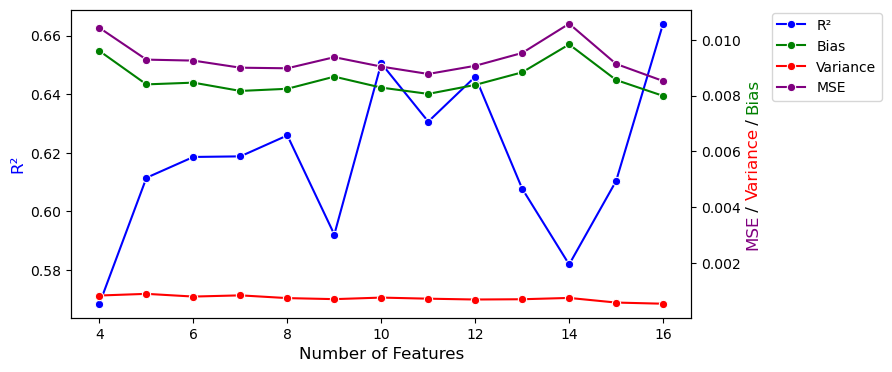

In [36]:
fig, ax1 = plt.subplots(figsize=(8, 4))

sns.lineplot(x=metrics_df.index, y=metrics_df['r2'], ax=ax1, marker='o', label='R²', color='blue')
ax1.set_xlabel("Number of Features", size=12)
ax1.set_ylabel("R²", size=12, color='blue')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.lineplot(x=metrics_df.index, y=metrics_df['bias'], ax=ax2, marker='o', label='Bias', color='green')
sns.lineplot(x=metrics_df.index, y=metrics_df['var'], ax=ax2, marker='o', label='Variance', color='red')
sns.lineplot(x=metrics_df.index, y=metrics_df['mse'], ax=ax2, marker='o', label='MSE', color='purple')

ax2.set_ylabel("")
ax2.tick_params(axis='y', labelcolor='black')

ax2.text(1.1, 0.72, "Bias", fontsize=12, color="green", 
         ha='center', va='center', rotation=90, transform=ax2.transAxes)
ax2.text(1.1, 0.635, " / ", fontsize=12, color="black", 
         ha='center', va='center', rotation=90, transform=ax2.transAxes)
ax2.text(1.1, 0.5, "Variance", fontsize=12, color="red", 
         ha='center', va='center', rotation=90, transform=ax2.transAxes)
ax2.text(1.1, 0.345, " /", fontsize=12, color="black", 
         ha='center', va='center', rotation=90, transform=ax2.transAxes)
ax2.text(1.1, 0.28, "MSE", fontsize=12, color="purple",
         ha='center', va='center', rotation=90, transform=ax2.transAxes)

ax2.legend().set_visible(False)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.13, 0.99), borderaxespad=0)

#plt.title("Metrics of Sequential Floating Backward Selection", fontsize=12, pad=20, y=0.96)
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/SBFS_04_05_Metrics.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

### Step 6: Evaluate the performace of the test set

In [37]:
# Create Dataframe with the actual & predicted values along with other columns    
plotting_df = pd.DataFrame({'Source_ID': groups_test,'Date': dates_test,'Actual_SENTEK_SMC': y_test,'Predicted_SENTEK_SMC': y_pred})    
source_column = complete_dataset[['Site_ID','DOY']]
merged_df = plotting_df.merge(source_column, left_index=True, right_index=True, how='left')
merged_df['Source_ID'] = merged_df['Source_ID'].astype('category')

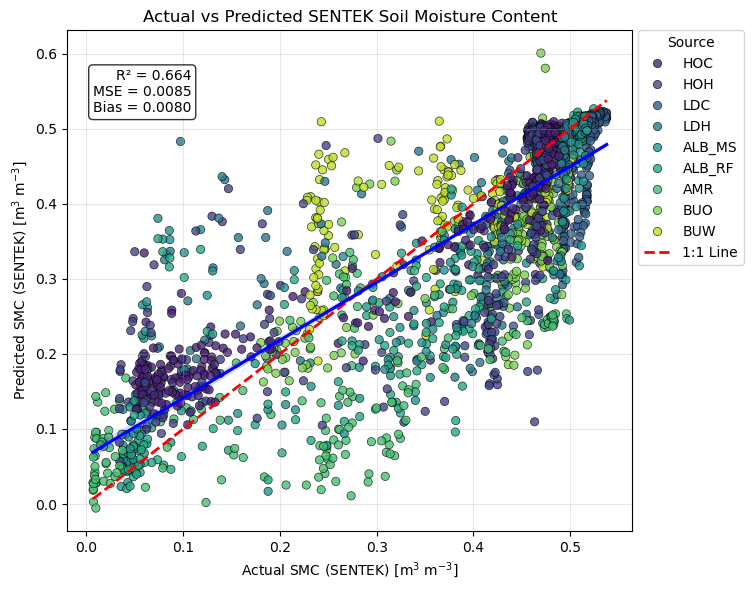

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Actual_Predicted_SBFS_04_05.png


In [42]:
plt.figure(figsize=(9, 6))
ax1 = sns.scatterplot(data=merged_df, x='Actual_SENTEK_SMC', y='Predicted_SENTEK_SMC', 
                      hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8)
x_vals = np.linspace(merged_df['Actual_SENTEK_SMC'].min(), merged_df['Actual_SENTEK_SMC'].max(), 100)
plt.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2, label="1:1 Line")
sns.regplot(data=merged_df, x='Actual_SENTEK_SMC', y='Predicted_SENTEK_SMC', 
            scatter=False, color='blue', line_kws={'label': "Regression Line"})
metrics_text = (
    f"R² = {r2:.3f}\n"
    f"MSE = {mse:.4f}\n"
    f"Bias = {bias:.4f}"
)

plt.text(0.22, 0.83, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
plt.title('Actual vs Predicted SENTEK Soil Moisture Content')
plt.xlabel('Actual SMC (SENTEK) [m$^{3}$ m$^{-3}$]')
plt.ylabel('Predicted SMC (SENTEK) [m$^{3}$ m$^{-3}$]')
plt.legend(title='Source', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)           
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend
plt.show()

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Actual_Predicted_SBFS_04_05.png"  
#ax1.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")

In [43]:
# save metrics dataframe
metrics_df.to_csv("C:/Data_MSc_Thesis/Results/SBFS_Run_3_metrics.csv")

# save top features dict as string in textfile
text_file = "C:/Data_MSc_Thesis/Results/SBFS_Trail_Run_3_top_features.txt"

f = open(text_file,"w")
f.write( str(results) )   # write file
f.close()                 # close file